# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [2]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

In [3]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [4]:
fifa = pd.read_csv("fifa.csv")

In [5]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [7]:
pd.options.display.max_columns = None

In [8]:
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [9]:
fifa.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Crossing,18159.0,49.734181,18.364524,5.0,38.0,54.0,64.0,93.0
Finishing,18159.0,45.550911,19.525820,2.0,30.0,49.0,62.0,95.0
HeadingAccuracy,18159.0,52.298144,17.379909,4.0,44.0,56.0,64.0,94.0
ShortPassing,18159.0,58.686712,14.699495,7.0,54.0,62.0,68.0,93.0
Volleys,18159.0,42.909026,17.694408,4.0,30.0,44.0,57.0,90.0
Dribbling,18159.0,55.371001,18.910371,4.0,49.0,61.0,68.0,97.0
Curve,18159.0,47.170824,18.395264,6.0,34.0,48.0,62.0,94.0


In [24]:
fifa.isna().sum()

Age                 0
Overall             0
Potential           0
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
GKDiving           48
GKHandling         48
GKKicking          48
GKPositioning      48
GKReflexes         48
dtype: int64

In [29]:
fifa.dropna(inplace=True)

In [113]:
def pca(datas, **kwargs):
    return PCA(**kwargs).fit(datas)

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [114]:
def q1():
    fit_pca = pca(fifa, n_components=1)
    fit_pca.transform(fifa)
    variance = fit_pca.explained_variance_ratio_[0]
    return float(np.round(variance, 3))
q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [98]:
fit_pca = pca(fifa, n_components=.95)
evr = fit_pca.explained_variance_ratio_

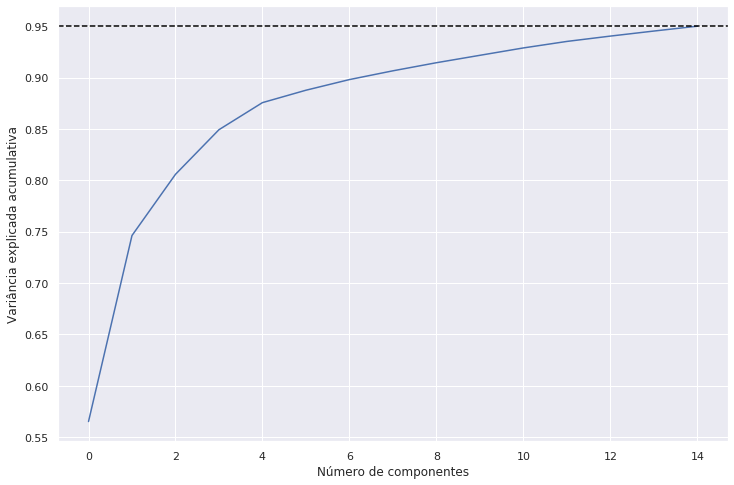

In [99]:
plot = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
plot.axes.axhline(.95, ls='--', color='#000000')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulativa')
#plt.show()

In [127]:
def q2():
    fit_pca = pca(fifa, n_components=.95)    
    return len(fit_pca.components_)
q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [76]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [144]:
def q3():
    pca_component_1 = pca(fifa, n_components=2)
    coors = np.dot(pca_component_1.components_, x).round(3).reshape(1, -1)[0]
    
    return coors[0], coors[1]
    
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [146]:
regressor = LinearRegression()

In [155]:
X = fifa.drop('Overall', axis=1)
y = fifa['Overall']

In [156]:
rfe = RFE(regressor, n_features_to_select=5)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=5)

In [184]:
rfe.get_support()

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [185]:
X.columns[rfe.get_support()]

Index(['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes'], dtype='object')

In [183]:
def q4():
    return list(X.columns[rfe.get_support()])
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']